In [73]:
%reset

In [74]:
import torch
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
import smogn
from sklearn.cluster import KMeans
import numpy as np
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from IPython.display import display
from scipy.stats import shapiro
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import abc

In [75]:
train_data = pd.read_csv("../data/train_data.csv")
train_data

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


#### Shapiro Test

In [76]:
res = shapiro(train_data["Size(sqf)"])
res

ShapiroResult(statistic=0.9201284440300943, pvalue=2.836132240475931e-42)

#### Set up criteria for classifying the data

In [77]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

#### Discover & research of the dataset

In [78]:
for column in train_data.columns:
    print(f"Number of unique rows in {column}: {train_data[column].nunique()}")

Number of unique rows in SalePrice: 841
Number of unique rows in YearBuilt: 16
Number of unique rows in Size(sqf): 89
Number of unique rows in Floor: 43
Number of unique rows in HallwayType: 3
Number of unique rows in HeatingType: 2
Number of unique rows in AptManageType: 2
Number of unique rows in N_Parkinglot(Ground): 23
Number of unique rows in N_Parkinglot(Basement): 20
Number of unique rows in TimeToBusStop: 3
Number of unique rows in TimeToSubway: 5
Number of unique rows in N_manager: 9
Number of unique rows in N_elevators: 13
Number of unique rows in SubwayStation: 8
Number of unique rows in N_FacilitiesInApt: 9
Number of unique rows in N_FacilitiesNearBy(Total): 11
Number of unique rows in N_SchoolNearBy(Total): 14


In [79]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

In [80]:
def to_discrete(value):
    if value > CRITERIUM_MAX_AVERAGE:
        return 2
    elif value > CRITERIUM_MAX_CHEAP:
        return 1
    else:
        return 0

In [81]:
discrete_column = train_data["SalePrice"].apply(to_discrete)
discrete_column.value_counts()

SalePrice
1    2992
2     570
0     562
Name: count, dtype: int64

In [82]:
def classify(tensor) -> torch.tensor:
    return torch.where(
        tensor > CRITERIUM_MAX_AVERAGE,
        torch.tensor(2),
        torch.where(
            (tensor > CRITERIUM_MAX_CHEAP) & (tensor <= CRITERIUM_MAX_AVERAGE),
            torch.tensor(1),
            torch.tensor(0),
        ),
    )

In [83]:
def count_unique_elements(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    for unique, count in zip(unique_elements, counts):
        print(f"Class {unique.item()}: {count.item()} occurrences")

# Create a dataset class

In [84]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        self.label = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.float32)
        self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        return

    def shuffle(self):
        self.data.sample(frac=1)

# Create a dataset class for regression

In [85]:
class HouseDatasetRegression(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)

    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        rows_to_duplicate_min = self.data[(self.data.iloc[:, 0] < CRITERIUM_MAX_CHEAP)]
        rows_to_duplicate_max = self.data[self.data.iloc[:, 0] > CRITERIUM_MAX_AVERAGE]
        self.data = pd.concat(
            [
                self.data,
                rows_to_duplicate_min.loc[
                    rows_to_duplicate_min.index.repeat(number_of_duplicates + 3)
                ],
                rows_to_duplicate_max.loc[
                    rows_to_duplicate_max.index.repeat(number_of_duplicates)
                ],
            ],
            ignore_index=True,
        )

    def _conduct_smogn(self) -> None:
        rg_mtrx = [
            [CRITERIUM_MAX_CHEAP, 1, 0],
            [CRITERIUM_MAX_AVERAGE, 0, 0],
            [500000, 1, 0],
        ]
        self.data = smogn.smoter(
            data=self.data,
            y=OUTPUT_COLUMN,
            rel_thres=0.98,
            samp_method="extreme",
            k=3,
            rel_method="manual",
            rel_ctrl_pts_rg=rg_mtrx,
        )

    def conduct_smote(self) -> None:
        smote = RandomOverSampler(shrinkage=0.5, random_state=42)
        x, y = smote.fit_resample(self.data, self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

    def cluster_kmeans(self, k: int = 3) -> None:
        model = KMeans(n_clusters=k)
        model = model.fit(self.data)
        labels = model.predict(self.data)
        return labels

# Create a dataset class for classification

In [86]:
train_path = "../data/split_train_data/train_data.csv"
val_path = "../data/split_train_data/val_data.csv"
scaler = StandardScaler()

In [87]:
train_dataset= HouseDatasetRegression(train_path, scaler)
train_dataset.prepare_for_training()

val_dataset = HouseDatasetRegression(val_path, scaler)

In [88]:
# train_dataset.prepare_for_training()
train_data_df = train_dataset.get_data_as_pandas()
# sns.heatmap(train_data.corr())

<Axes: >

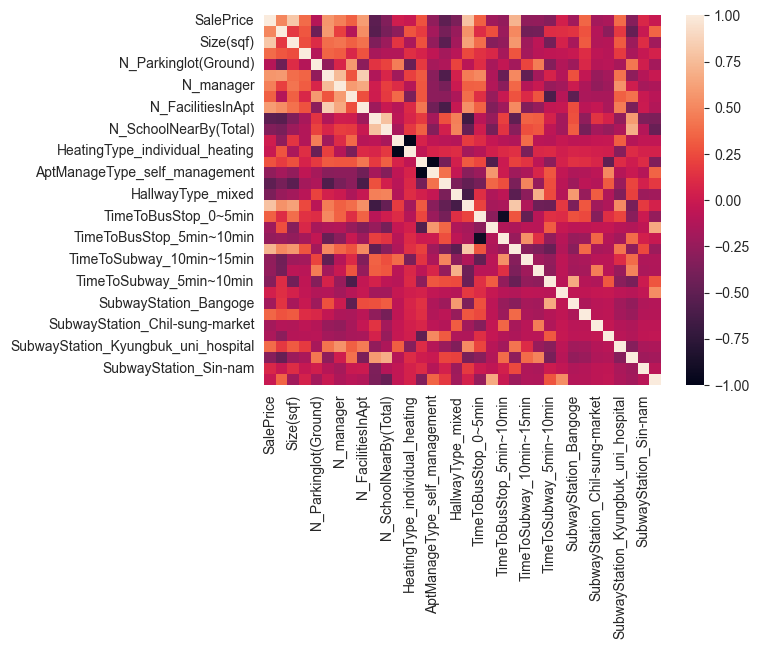

In [89]:
train_data_df
sns.heatmap(train_data_df.corr())

In [90]:
train_data_df.iloc[:, 0].apply(to_discrete).value_counts()

SalePrice
1    2005
0    1815
2     782
Name: count, dtype: int64

In [91]:
train_data_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,75920.0,0.202324,-1.019485,0.641248,-0.571717,0.535631,-0.096317,-1.424494,0.480494,0.928305,...,2.021979,-0.199736,2.634323,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
1,260176.0,0.432564,-0.245248,-0.400815,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562
2,389380.0,1.353523,-0.124927,-0.661331,-0.064211,1.812055,0.522575,1.687281,1.751334,-1.102500,...,2.021979,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,3.628943
3,79203.0,-1.294234,-1.009022,0.120216,0.053267,-1.411954,-0.405763,-0.127921,-1.213960,1.798650,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
4,218584.0,-1.179114,1.279685,1.683310,1.571086,-0.103802,0.522575,1.168652,-0.790347,1.218420,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,362831.0,0.432564,1.457550,0.510990,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562
4598,406194.0,0.432564,1.261375,2.074084,-0.853665,0.064598,-0.405763,-0.776208,-0.366733,-0.232155,...,-0.494565,-0.199736,-0.379604,2.638662,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
4599,362831.0,0.317444,2.862162,0.120216,0.283524,-0.103802,-0.405763,0.001736,-0.366733,-1.972845,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,2.844084,-0.275562
4600,448672.0,0.432564,1.904829,0.510990,-0.853665,0.064598,-0.405763,-0.776208,-0.366733,-0.232155,...,-0.494565,-0.199736,-0.379604,2.638662,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562


In [92]:
labels = classify(train_dataset.label)
count_unique_elements(labels)

Class 0: 1815 occurrences
Class 1: 2005 occurrences
Class 2: 782 occurrences


In [93]:
train_dataset.size

4602

#### Split the data into training and validation sets

In [94]:
# X_train, X_test, y_train, y_test = train_test_split(
#     train_dataset.data, train_dataset.label, test_size=0.33, random_state=42
# )
# train_data = data.TensorDataset(X_train, y_train)
# validation_data = data.TensorDataset(X_test, y_test)

#### Create the data loaders

In [95]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [96]:
class HousingRegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 56)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(56, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [97]:
model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
loss_fn = nn.MSELoss()
mca = MulticlassAccuracy(num_classes=3, average=None)

In [98]:
EPOCHS_NUMBER = 800
train_losses, train_accuracies, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(validation_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data, label in train_loader:
        model_output = model(data).squeeze()
        loss = loss_fn(model_output, label.type(torch.FloatTensor)) 
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        train_predicts_classify = classify(model_output)
        train_data_classify = classify(label)
        train_batch_accuracy_sum += mca(train_predicts_classify, train_data_classify)
        train_batch_f1_score_sum += f1_score(train_predicts_classify,train_data_classify, average="micro")

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num
    train_batch_f1_score_avg = train_batch_f1_score_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)
    train_f1_scores.append(train_batch_f1_score_avg)

    model.eval()
    for val_inputs, val_labels in validation_loader:
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = loss_fn(val_predicts, val_labels.type(torch.LongTensor))
        val_batch_loss_sum += val_loss.item()
        val_predicts_classify = classify(val_predicts)
        val_data_classify = classify(val_labels)
        val_batch_accuracy_sum += mca(val_predicts_classify, val_data_classify)
        val_batch_f1_score_sum += f1_score(
            val_predicts_classify, val_data_classify, average="micro"
        )
    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num
    val_batch_f1_score_avg = val_batch_f1_score_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)
    val_f1_scores.append(val_batch_f1_score_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
            "f1 in train": {train_batch_f1_score_avg},
            "f1 in eval": {val_batch_f1_score_avg},
        }
    )

100%|██████████| 800/800 [04:27<00:00,  3.00it/s, Epoch=800, Los in train={1880888908.4444444}, Loss in eval={1545717746.6666667}, f1 in train={0.8255375267094016}, f1 in eval={0.8432992788461539}]


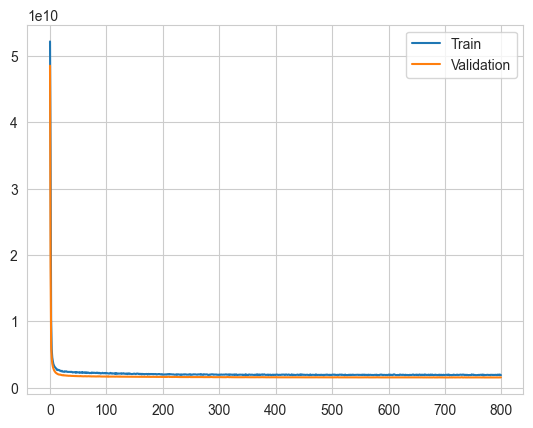

In [99]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()

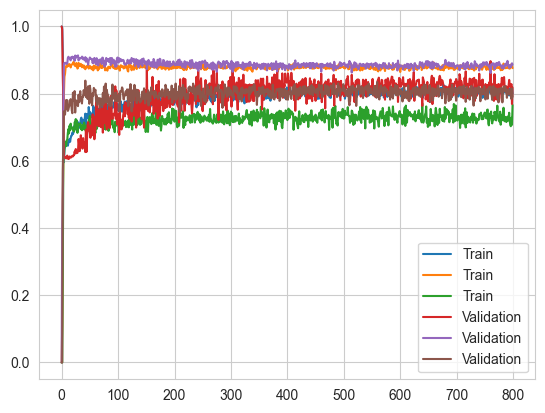

In [100]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [101]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

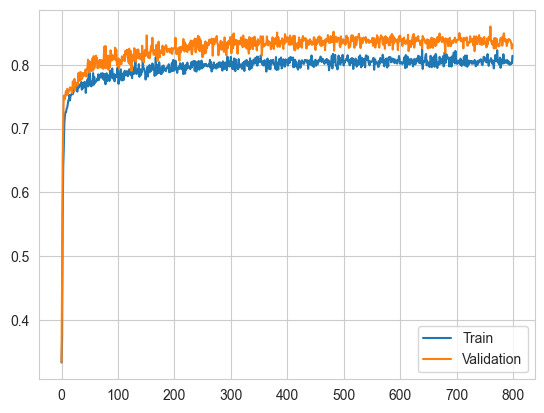

In [102]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()

In [103]:
val_accuracies

[tensor([1., 0., 0.]),
 tensor([0.9918, 0.4013, 0.0000]),
 tensor([0.8617, 0.5051, 0.5692]),
 tensor([0.7711, 0.6890, 0.6679]),
 tensor([0.6176, 0.8895, 0.7475]),
 tensor([0.6119, 0.8915, 0.7458]),
 tensor([0.6089, 0.8915, 0.7376]),
 tensor([0.6109, 0.8920, 0.7587]),
 tensor([0.6072, 0.8882, 0.7812]),
 tensor([0.6106, 0.8890, 0.7563]),
 tensor([0.6157, 0.8900, 0.7805]),
 tensor([0.6064, 0.9063, 0.7487]),
 tensor([0.6084, 0.9099, 0.7528]),
 tensor([0.6062, 0.9072, 0.7608]),
 tensor([0.6131, 0.9051, 0.7654]),
 tensor([0.6121, 0.9025, 0.7794]),
 tensor([0.6097, 0.8992, 0.7838]),
 tensor([0.6105, 0.9088, 0.7702]),
 tensor([0.6138, 0.9075, 0.7495]),
 tensor([0.6149, 0.9102, 0.7419]),
 tensor([0.6133, 0.9053, 0.8027]),
 tensor([0.6172, 0.9089, 0.7803]),
 tensor([0.6169, 0.9043, 0.7954]),
 tensor([0.6279, 0.8977, 0.8077]),
 tensor([0.6221, 0.9135, 0.7439]),
 tensor([0.6352, 0.9064, 0.7756]),
 tensor([0.6229, 0.9079, 0.7797]),
 tensor([0.6232, 0.9125, 0.7666]),
 tensor([0.6238, 0.9103, 0.7676]

In [104]:
# model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)
# model.load_state_dict(torch.load("../models/housing_model_3_85_6.pth"))

In [105]:
with torch.no_grad():
    predicts_train = model(train_dataset.data.clone().detach())
    predicts_val = model(val_dataset.data.clone().detach())
    predicts_classified_train = classify(predicts_train)
    predicts_classified_val = classify(predicts_val)
    y_train_classified = classify(train_dataset.label.clone().detach())
    y_test_classified = classify(val_dataset.label.clone().detach())

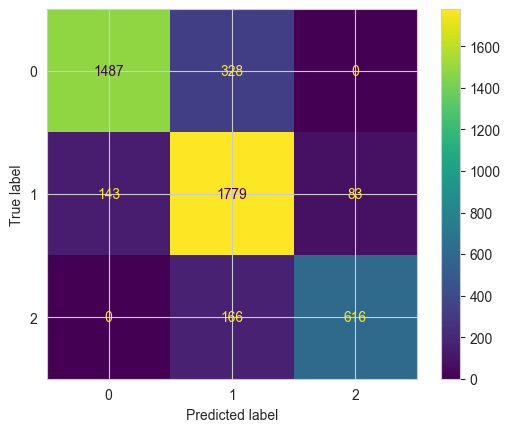

In [106]:
conf_matrix = confusion_matrix(y_train_classified, predicts_classified_train)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

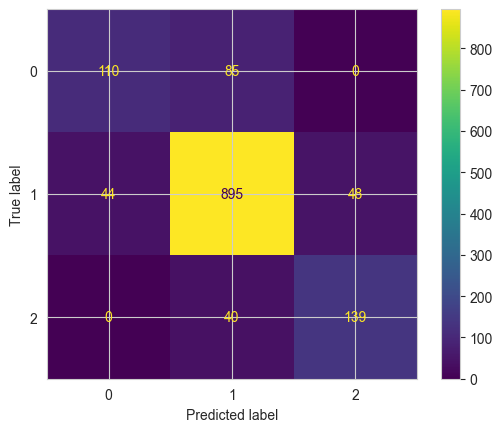

In [107]:
conf_matrix_val = confusion_matrix(y_test_classified, predicts_classified_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [108]:
f1_score(y_test_classified, predicts_classified_val, average="micro")

0.8405584129316679

In [119]:
mca(y_test_classified, predicts_classified_val.squeeze())

tensor([0.7143, 0.8775, 0.7433])

In [117]:
y_test_classified.shape

torch.Size([1361])

In [118]:
predicts_classified_val.shape

torch.Size([1361, 1])

In [109]:
# torch.save(model.state_dict(), "../models/housing_model_2.pth")
# 64 last

In [110]:
# torch.save(model.state_dict(), "../models/housing_model_3_83_7.pth")
# 32 last

In [111]:
# torch.save(model.state_dict(), "../models/housing_model_3_84.pth")

In [112]:
# torch.save(model.state_dict(), "../models/housing_model_3_85_6.pth")

In [113]:
# torch.save(model.state_dict(), "../models/housing_model_the_best.pth")